# Analisis del flujo vehicular en la ciudad de Buenos Aires y su impacto en la calidad del aire

## Un analisis de correlacion entre los datos del flujo vehicular en la ciudad, tomados entre el 05 de marzo y el 30 de noviembre de 2020 y los indices de calidad del aire recopilados por las estaciones Parque Centenario y Cordoba

### Luis Andres Marquez Vergara,  para participación en #BAenDatos 15/12/2020
https://github.com/luisandres248

Para este estudio utilicé las bases de datos disponibles en https://data.buenosaires.gob.ar/ de donde descargué las correspondientes a flujo vehicular e Indices de calidad del aire.
Mi hipotesis era que teniendo estos datos en los periodos pre y durante el aislamiento obligatorio que comenzó en marzo de este año podria obtener una correlación y posteriormente construir un modelo para saber que impacto puede tener la reduccion o aumento del flujo vehicular sobre estos indices de calidad del aire
De esta forma se podria estimar en cuanto podemos mejorar los indices si el flujo vehicular se redujera por aplicación de medidas gubernamentales y de optimizacion de la vialidad y servicios de transporte masivo

## Datos

Cargué las tres bases de datos que utilicé, las dos antes mencionadas y una tercera sobre las temperaturas medias de la ciudad tomadas diariamente en un periodo de varios años, esta fue extraida de "University of Dayton - Environmental Protection Agency Average Daily Temperature Archive,
http://academic.udayton.edu/kissock/http/Weather/default.htm "

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import xlrd
import seaborn as sn

df_vehiculos = pd.read_csv('dataset_flujo_vehicular.csv')
df_aire = pd.read_csv('calidad-aire.csv')
df_temp = pd.read_excel('AGBUENOS.xls')
#transformaciones al dataset de flujo vehicular
df_vehiculos.drop(columns=['CODIGO_LOCACION','SENTIDO']) #elimino columnas 
df_vehiculos['HORA'] = pd.to_datetime(df_vehiculos['HORA'],  format='%d%b%Y:%H:%M:%S').dt.date  #cambio de formato de la fecha
df_vehiculos = df_vehiculos.groupby('HORA', as_index=False)['CANTIDAD'].sum() #totalizar los registros por dia
df_vehiculos = df_vehiculos.rename(columns={'HORA':'FECHA'}) 
#transformaciones al dataset de calidad del aire
df_aire = df_aire.drop(columns = ['HORA','CO_PALERMO','NO2_PALERMO','PM10_PALERMO','CO_LA_BOCA','NO2_LA_BOCA','PM10_LA_BOCA'])
df_aire = df_aire.astype('str') 
col = df_aire.columns[1:]
def remove_chars(s): #funcion para eliminar caracteres no numerios de las columnas para poder utilizarlas
    return re.sub('[^0-9]+', '', s) 
for i in col:
    df_aire[i] = df_aire[i].apply(remove_chars)
df_aire = df_aire.replace(r'^\s*$', np.nan, regex=True) #reemplazo vacios por NANs
df_aire['FECHA'] = pd.to_datetime(df_aire['FECHA'],  format='%d%b%Y:%H:%M:%S').dt.date  #formato correcto para fecha
df_aire = df_aire.astype({'CO_CENTENARIO':'float','NO2_CENTENARIO':'float','PM10_CENTENARIO':'float', #columnas a float
                          'CO_CORDOBA':'float','NO2_CORDOBA':'float','PM10_CORDOBA':'float'})
df_aire['CO_CENTENARIO'] = df_aire['CO_CENTENARIO'] / 100 #divido entre 100 estas dos columnas para obtener el mismo orden de magnitud que las originales
df_aire['CO_CORDOBA'] = df_aire['CO_CORDOBA'] / 100
df_aire = df_aire.groupby('FECHA', as_index=False).mean() #totalizo los registros diarios con la media correspondiente
#transformaciones del dataset de temperaturas
df_temp['FECHA'] = pd.to_datetime(df_temp['FECHA']).dt.date
#union de los dataframes
df_merged = df_vehiculos.merge(df_aire, on = 'FECHA')
df_merged = df_merged.merge(df_temp, on ='FECHA')
df_merged['CO_CORDOBA'] = df_merged['CO_CORDOBA'].fillna(df_merged['CO_CORDOBA'].mean()) #reemplazar faltantes por la media
df_merged['NO2_CORDOBA'] = df_merged['NO2_CORDOBA'].fillna(df_merged['NO2_CORDOBA'].mean())
df_merged['PM10_CORDOBA'] = df_merged['PM10_CORDOBA'].fillna(df_merged['PM10_CORDOBA'].mean())
df_merged = df_merged.set_index('FECHA')
df_merged = df_merged.asfreq('d') 
df_merged

,CANTIDAD,CO_CENTENARIO,NO2_CENTENARIO,PM10_CENTENARIO,CO_CORDOBA,NO2_CORDOBA,PM10_CORDOBA,°C
FECHA,,,,,,,,
2020-03-02,1054661,0.557917,18.958333,24.125000,0.422500,14.500000,24.041667,28.500000
2020-03-03,1069378,0.520417,15.625000,22.583333,0.440833,14.041667,29.200000,26.666667
2020-03-04,1090640,0.432500,15.590909,22.333333,0.465417,13.541667,18.612840,25.888889
2020-03-05,1131111,0.225417,13.291667,19.083333,0.403333,11.875000,18.612840,25.388889
2020-03-06,1178058,0.290417,15.541667,18.083333,0.408750,13.166667,18.612840,24.666667
...,...,...,...,...,...,...,...,...
2020-11-29,401791,0.558750,9.416667,19.750000,0.837917,28.125000,14.291667,24.388889
2020-11-30,643894,0.407917,8.541667,24.041667,0.527083,25.416667,21.666667,21.555556
2020-12-01,683532,0.493333,12.000000,20.416667,0.504583,28.958333,16.458333,18.500000


En la tabla que vemos arriba tenemos los registros entre el 2 de marzo y el 3 de diciembre para las columnas.

CANTIDAD: Suma del flujo vehicular total detectado por los sensores en la ciudad.

°C: Representa la temperatura media en grados centigrados.

Y CO, NO2, y PM10 para ambas estaciones CENTENARIO y CORDOBA donde se registran los valores promedio de cada uno de estos indicadores

Text(0, 0.5, 'TEMPERATURA °C')

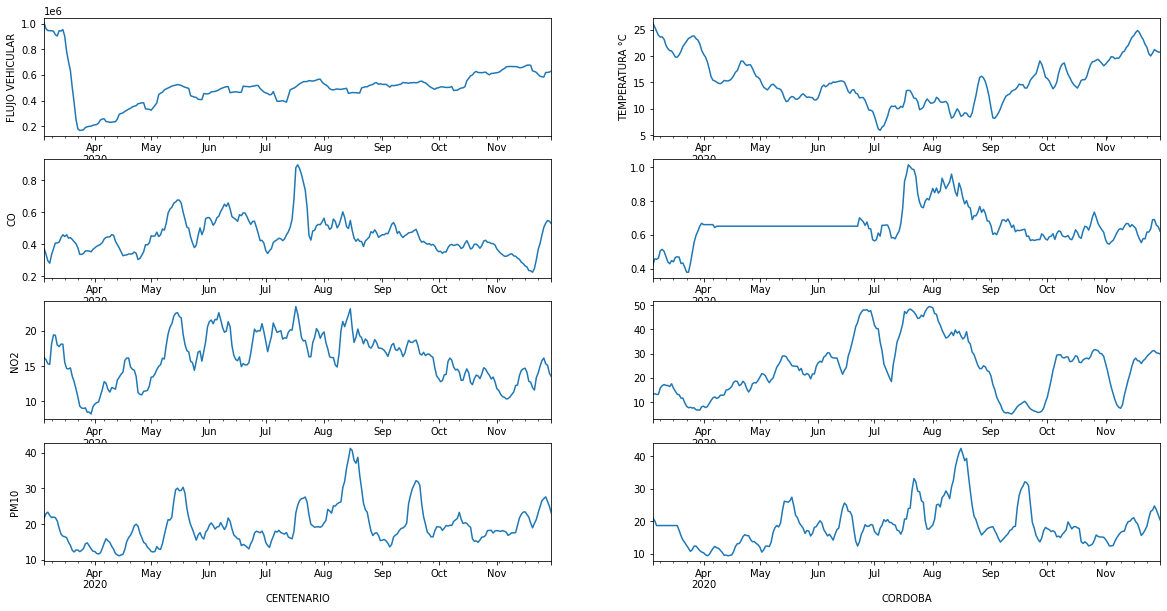

In [2]:
"""Utilizo un metodo para descomponer cada serie de tiempo en sus componentes trend, seasonal y resid, 
   de manera de eliminar el efecto de variación que genera los dias laborales contra los fines de semana
   y trabajar solo con la componente trend"""
df_trends = df_merged.copy()
columnas = df_trends
for i in columnas:
    df_trends[i] = seasonal_decompose(df_trends[i], model='additive').trend
df_trends = df_trends.dropna()

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,10))
ylabels = ['FLUJO VEHICULAR','CO','NO2','PM10']
for i,var in enumerate(['CANTIDAD','CO_CENTENARIO','NO2_CENTENARIO','PM10_CENTENARIO']):
    df_trends[var].plot(ax=axes[i,0], title=[])
    axes[i,0].tick_params(axis='x', which='major', labelsize=10,labelbottom='off' )
    axes[i,0].set_ylabel(ylabels[i])
for i,var in enumerate(['°C','CO_CORDOBA','NO2_CORDOBA','PM10_CORDOBA']):
    df_trends[var].plot(ax=axes[i,1], title=[]) 
    axes[i,1].tick_params(axis='x', which='major', labelsize=10 ,labelbottom='off')
    axes[i,1].set_xlabel('')
axes[3,0].set_xlabel('CENTENARIO')
axes[3,1].set_xlabel('CORDOBA')
axes[0,1].set_ylabel('TEMPERATURA °C')

En estas graficas arriba se puede ver la serie de datos respecto al periodo de tiempo de estudio.

La de CANTIDAD en la esquina superior izquierda muestra claramente el descenso abruto en el flujo vehicular causado por el decreto de aislamiento obligatorio y luego como se va recuperando la actividad a medida que avanza el año, desafortunadamente estos datos comienzan pocos dias antes de dicho decreto por lo que tenemos pocos dias para comparar aunque de igual forma se puede observar las difrencias.

Una de las primera conclusiones que obtuve fue al ver como en general todas las mediciones de los contaminantes en el aire experimentan una reduccion en sus niveles de manera proporcional a la reduccion del flujo vehicular para el periodo Marzo-Abril, pero luego, no siguen la misma tendencia del flujo vehicular sino que experimentan una especie de parabola que se ve mas claramente en la grafica de NO2_CENTENARIO, para explicar ese comportamiento que no se corresponde con el del flujo vehicular incluí el dataset de Temperaturas, la cual claramente se corresponde de forma inversamente proporcional a las mediciones de contaminantes. De este comportamiento lo que puedo deducir es que el efecto del descenso de la temperatura y como cosecuencia presumiblemente el aumento del uso de calefacción genera un aumento muy apreciable en los contaminantes del aire, que se suma al del flujo vehicular.

De esta forma ahora tenemos 2 variables independientes, la Temperatura y el Flujo vehicular, con las cuales podria calcular los indices de calidad del aire que dependerian de ellas. 

## Analisis y modelado

<AxesSubplot:>

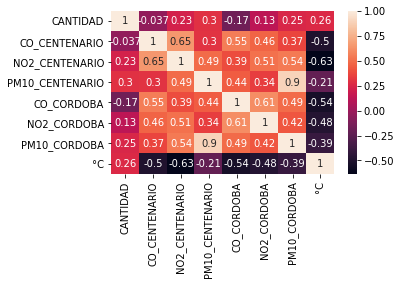

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,3))
corrMatrix2 = df_trends.corr()
axes = sn.heatmap(corrMatrix2, annot=True)
axes

Esta es una matriz de correlación lineal entre las columnas de datos, si bien no hay correlaciones tan marcadas para los indices de contaminacion contra la cantidad y temperatura, si se puede observar una influencia entre ellas, por lo que a continuacion planteo un modelo de prediccion que toma los valores de Flujo Vehicular y Temperatura y da como resultado los valores de los indices de contaminacion, de esta forma podria calcular despues la influencia de una reduccion de la movilidad vehicular sobre estos indices de calidad del aire

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
columnas = df_trends.columns
column = columnas[1:-1]
df_trends_predict = dict.fromkeys(column) #diccionario para guardas las predicciones
df_trends_test = dict.fromkeys(column) #diccionario para guardas las series de test
scores = dict.fromkeys(column) #diccionario para guardas los scores de los modelos
#loop para hacer un modelo para cada una de las columnas de contaminantes
for i in column:
    x = df_trends[[columnas[0],columnas[-1]]]
    y = df_trends[i]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    model_trends = RandomForestRegressor(oob_score = True,n_estimators=500, bootstrap = True)
    model_trends.fit(X_train,y_train)
    df_trends_predict[i] = model_trends.predict(X_test)
    df_trends_test[i] = y_test
    scores[i] = model_trends.score(X_test,y_test)
#calculo de la raiz del error cuadratico medio como medida para evaluar las predicciones del modelo
rmse = dict.fromkeys(column)
for i in column:
    rmse[i] = mean_squared_error(df_trends_test[i],df_trends_predict[i], squared=False)
scores

{'CO_CENTENARIO': 0.25795587421682586,
 'NO2_CENTENARIO': 0.7034800803123417,
 'PM10_CENTENARIO': 0.46977064037313,
 'CO_CORDOBA': 0.6448467428106714,
 'NO2_CORDOBA': 0.5220193752636867,
 'PM10_CORDOBA': 0.44013821971898226}

Con los scores que se muetran arriba se puede ver que si bien no hay mucha precision para la mayoria de los indices, si se podria estimar un valor al menos en principio para el NO2_CENTENARIO, el cual en las diferentes pruebas es el que mejor se comporta. Con mas datos, tiempo y trabajo se podria mejorar los resultados y obtener mayor precision y confiabilidad.

In [5]:
df_trends_test_2 = pd.DataFrame(df_trends_test)
df_trends_test_2.describe()

,CO_CENTENARIO,NO2_CENTENARIO,PM10_CENTENARIO,CO_CORDOBA,NO2_CORDOBA,PM10_CORDOBA
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,0.468812,15.931686,20.299784,0.638646,23.673210,18.948246
std,0.114300,3.351107,6.349557,0.089047,10.928721,5.386752
min,0.258988,8.470238,12.160714,0.433257,5.339286,9.656746
25%,0.396042,13.862836,15.690476,0.590685,15.735171,15.284348
50%,0.443750,15.238095,19.220238,0.650933,24.333333,18.259491
75%,0.525565,18.465909,23.380952,0.650933,29.243197,23.275747
max,0.878274,22.409091,37.875000,0.945000,49.250000,32.072067


como datos adicionales podemos ver la diferencia entre la desviacion estandar (STD) de los datos originales en la tabla de arriba y la Raiz del Error Cuadratico Medio de los valores calculados con el modelo que estan a continuación

In [6]:
rmse

{'CO_CENTENARIO': 0.09756131816998985,
 'NO2_CENTENARIO': 1.8081345016102666,
 'PM10_CENTENARIO': 4.581322246497432,
 'CO_CORDOBA': 0.0525829196768226,
 'NO2_CORDOBA': 7.4866928647596716,
 'PM10_CORDOBA': 3.9937689324703003}

## Conclusiones

Para obtener una conclusion en cuanto a el efecto de reducir solo el flujo vehicular sobre los indices de calidad del aire, se puede tener la media de todos los valores para los dias antes del decreto, y de igual forma para un periodo de un mes despues del decreto. Luego para cada caso, antes y despues, reduzco el valor del flujo vehicular en un 20% y mediante el modelo creado obtengo los indices de contaminantes.

Como se tienen pocos datos (aproximadamente 10 dias) antes del efecto del decreto, los resultados para este periodo no serian muy confiables, pero para tener un punto de comparacion utilizo ese periodo y luego los datos de 30 dias continuos luego de haber pasado 1 mes de salir el decreto de aislamiento.

In [7]:
#medias del conjunto de datos antes y despues del decreto 
df_antes = df_trends[:10].mean()
df_despues = df_trends[30:60].mean()
#separacion para pasarlos por el modelo
media_features_antes = df_antes[['CANTIDAD','°C']]
media_aire_antes = df_antes[columnas[1:-1]]
media_features_despues = df_despues[['CANTIDAD','°C']]
media_aire_despues = df_despues[columnas[1:-1]]
#datos con la reduccion del 20%
reduccion_features_antes = media_features_antes.copy()
reduccion_features_despues = media_features_despues.copy()
reduccion_features_antes['CANTIDAD'] = reduccion_features_antes['CANTIDAD'] * 0.8
reduccion_features_despues['CANTIDAD'] = reduccion_features_despues['CANTIDAD'] * 0.8
#modelo que procesa todos los datos al mismo tiempo
model_trends2 = RandomForestRegressor(oob_score = True,n_estimators=300, bootstrap = True, random_state = 4 )
model_trends2.fit(df_trends[['CANTIDAD','°C']],df_trends[columnas[1:-1]])
#predicciones del modelo para antes y despues sin alterar los datos
pred_antes = model_trends2.predict(media_features_antes.values.reshape(1,-1))
pred_despues = model_trends2.predict(media_features_despues.values.reshape(1,-1))
#prediccion del modelo para antes y despues con la reduccion del 20% del flujo vehicular
pred_reduccion_antes = model_trends2.predict(reduccion_features_antes.values.reshape(1,-1))
pred_reduccion_despues = model_trends2.predict(reduccion_features_despues.values.reshape(1,-1))
#filas de porcentajes
porcentual_antes = (media_aire_antes.values - pred_reduccion_antes)/media_aire_antes.values
porcentual_antes  = porcentual_antes[0].tolist() 
porcentual_antes = ["{:.0%}".format(member) for member in porcentual_antes]
porcentual_despues = (media_aire_despues.values - pred_reduccion_despues)/media_aire_despues.values
porcentual_despues  = porcentual_despues[0].tolist() 
porcentual_despues = ["{:.0%}".format(member) for member in porcentual_despues]
#Unificacion de todo en un dataframe
list_antes = list([np.array(media_aire_antes,dtype=object).reshape(1,-1),pred_antes[0],pred_reduccion_antes[0],porcentual_antes])
DF_ANTES = pd.DataFrame(np.row_stack(list_antes), columns=(s + '_antes' for s in columnas[1:-1]))
list_despues = list([np.array(media_aire_despues,dtype=object).reshape(1,-1),pred_despues[0],pred_reduccion_despues[0],porcentual_despues])
DF_DESPUES = pd.DataFrame(np.row_stack(list_despues), columns=(s + '_despues' for s in columnas[1:-1]))
DF3= pd.concat([DF_ANTES , DF_DESPUES], axis=1)
DF3 = DF3[list(sum(zip(DF_ANTES.columns, DF_DESPUES.columns), ()))]
DF3['index'] = ['Original','Prediccion','Reduccion','Porcentaje']
DF4 = DF3.set_index('index',drop=True).copy()
DF4

,CO_CENTENARIO_antes,CO_CENTENARIO_despues,NO2_CENTENARIO_antes,NO2_CENTENARIO_despues,PM10_CENTENARIO_antes,PM10_CENTENARIO_despues,CO_CORDOBA_antes,CO_CORDOBA_despues,NO2_CORDOBA_antes,NO2_CORDOBA_despues,PM10_CORDOBA_antes,PM10_CORDOBA_despues
index,,,,,,,,,,,,
Original,0.367246,0.387357,17.3543,12.893,21.2952,14.4577,0.465312,0.651589,15.3018,15.826,18.9929,12.0643
Prediccion,0.350372,0.339521,18.0354,14.5882,21.4917,12.3056,0.493894,0.651242,15.9691,16.9629,18.6237,10.2469
Reduccion,0.268549,0.412232,14.1168,12.1076,22.2682,12.9574,0.623828,0.64846,25.6191,11.9275,19.6934,10.5207
Porcentaje,27%,-6%,19%,6%,-5%,10%,-34%,0%,-67%,25%,-4%,13%


En la tabla que tenemos arriba están los datos para cada uno de los contaminantes correspondientes a la cantidad promedio de flujo vehicular y temperatura antes y despues del decreto de aislamiento obligatorio.
Luego en las filas se puede ver la de datos orginales (promedio de varios dias), la siguiente fila sería la prediccion del modelo solo para observar que los valores que arroja son consistentes con los originales y luego en la fila denotada como "Reducción" se encuentran los datos correspondientes a la reduccion de un 20% del flujo vehicular para ambos periodos y sin alterar la temperatura correspondiente, lo cual nos da un porcentaje de disminución (en positivo) o aumento (porcentajes negativos) para cada contaminante expresados en la fila de "Porcentaje".

Como habiamos visto antes el modelo tiene mayor precision para calcular el indice de NO2_CENTENARIO, el cual tanto antes como despues del decreto experimentó un decrecimiento al igual que la mayoria de los indices.

Eso quiere decir que si reducimos en un 20% el flujo vehicular de la ciudad se podria disminuir entre un 6% y un 19% la cantidad de NO2 presente en el aire.

En la grafica siguiente estan los mismos valores  expresados en una grafica de barras para mejor visualización.

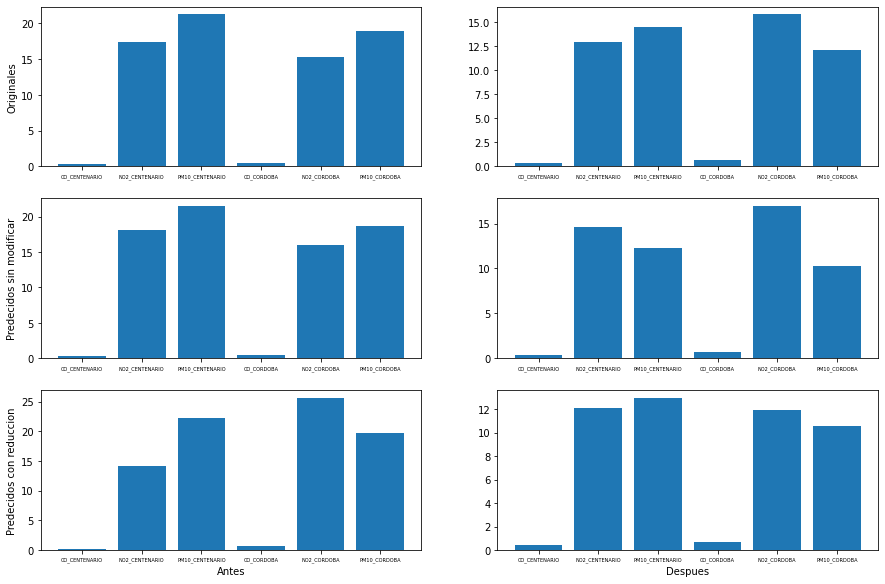

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))

axes[0,0].bar(columnas[1:-1],media_aire_antes)
axes[0,0].set_ylabel('Originales')
axes[0,1].bar(columnas[1:-1],media_aire_despues)
axes[1,0].bar(columnas[1:-1],pred_antes[0])
axes[1,0].set_ylabel('Predecidos sin modificar')
axes[1,1].bar(columnas[1:-1],pred_despues[0])
axes[2,0].bar(columnas[1:-1],pred_reduccion_antes[0])
axes[2,0].set_ylabel('Predecidos con reduccion')
axes[2,1].bar(columnas[1:-1],pred_reduccion_despues[0])
axes[2,0].set_xlabel('Antes')
axes[2,1].set_xlabel('Despues')
for i,ax in axes :
    ax.tick_params(axis='x', which='major', labelsize=5,labelbottom='off' )
    i.tick_params(axis='x', which='major', labelsize=5,labelbottom='off' )

Faltaria mucho trabajo y verificacion para que estos datos calculados tengan confiablidad estadistica aceptable, pero puede servir como un punto de partida para estudios mas profundos sobre la materia. El obetivo principal era probar de forma no muy rigurosa la hipotesis que tenia en cuanto a los efectos del flujo vehicular sobre los contaminantes del aire y organizarlo de forma visual y explicativa para mi participacion en el concurso organizado por el Gobierno de la Ciudad de Buenos Aires #BAenDatos.